# Introducción

> "Sometimes I think, how lucky we are to live in this time, the first moment in human history when we are, in fact visiting other worlds and engaging in a deep reconnaissance of the cosmos" — Carl Sagan

Cuando aún resonaban los ecos de la «expulsión» de Plutón de nuestro sistema planetario (o más bien, de su descenso a la división de los planetas enanos), de repente dos científicos del Instituto de Tecnología de California (Caltech para los amigos) publican un artículo en el que **hipotetizan la existencia de un planeta más masivo que la Tierra mucho más allá de la órbita de Neptuno**. Batygin y Brown, los responsables de la investigación, han bautizado a su _aún no observado_ descubrimiento como **Planeta Nueve**. No he podido evitar acordarme de la cita de Carl Sagan mientras escribía este artículo :)

Para los detalles de este fantástico avance y un análisis de sus implicaciones os remito a [los excelentes artículos de Daniel Marín en Eurekablog acerca del "Planeta Nueve"](http://danielmarin.naukas.com/2016/01/20/estrechando-el-cerco-alrededor-del-planeta-x/). En Pybonacci vamos a aportar nuestro granito de arena, y como apasionados de la astronomía y del software libre que somos, vamos a darle una pasada al [artículo original de Batygin y Brown](http://iopscience.iop.org/article/10.3847/0004-6256/151/2/22/pdf) (disponible libremente en PDF) y jugar con los datos que ofrece como más nos gusta: usando Python ;)

**Nota**: El análisis que se plantea a continuación no tiene el debido rigor científico y en ningún caso debe tomarse como un punto de partida para una búsqueda seria del Planeta Nueve. Dicho lo cual, si alguien lo encuentra gracias a este artículo por lo menos que me invite a un café :D

# Python + Órbitas = poliastro

Para este análisis vamos a utilizar [poliastro, una biblioteca Python para astrodinámica interplanetaria](http://poliastro.readthedocs.org/) que yo mismo estoy desarrollando. poliastro nos permitirá hacer cálculos con los elementos orbitales de los cuerpos que analicemos, y sus dependencias nos ayudarán en la tarea:

* Gracias a [astropy](http://astropy.org/) podremos hacer conversiones entre sistemas de referencia, utilizar unidades físicas y manejar tiempos con rigor astronómico ([algo nada fácil](https://twitter.com/astrojuanlu/status/686168336330272768)).
* La biblioteca [jplephem](https://pypi.python.org/pypi/jplephem) nos permitirá utilizar las efemérides del [Jet Propulsion Laboratory de la NASA](http://www.jpl.nasa.gov/) para localizar la posición de los planetas.

Además, y como es natural utilizaremos NumPy, SciPy y matplotlib. Para instalar todo lo necesario solo necesitas ejecutar un comando:

    $ conda install poliastro --channel poliastro

Y también usando pip (porque en el fondo me caéis bien):

    $ pip install numpy scipy matplotlib astropy jplephem poliastro

(Nótese que numba es opcional)

**Sin embargo**, escribiendo este artículo me he encontrado con cosas que no funcionaban y que he tenido que arreglar sobre la marcha, así que utilizaré una rama de desarrollo con algunos arreglos temporales:

In [1]:
!conda install -qy poliastro --channel poliastro  # Instala las dependencias con conda

Fetching package metadata: ..........
Solving package specifications: ............................................
# All requested packages already installed.
# packages in environment at /home/juanlu/.miniconda3/envs/planet9:
#
poliastro                 0.4.3                    py35_1    file:///home/juanlu/.miniconda3/conda-bld/linux-64/poliastro-0.4.3-py35_1.tar.bz2


In [1]:
!pip uninstall poliastro -y

Uninstalling poliastro-0.5.dev0:
  Successfully uninstalled poliastro-0.5.dev0
You are using pip version 8.0.1, however version 8.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
#!pip install -e /home/juanlu/Development/Python/poliastro.org/poliastro
!pip install https://github.com/poliastro/poliastro/archive/planet9-fixes.zip  # Instala la versión de desarrollo

     / 966kB 14.7MB/s
  Running setup.py bdist_wheel for poliastro ... - \ | done
  Stored in directory: /home/juanlu/.cache/pip/wheels/98/83/5a/a5215dd3aaeec3828aca873c4342bc05b4b53605e31c1d1d60
Successfully built poliastro
You are using pip version 8.0.1, however version 8.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
%load_ext version_information

In [5]:
%version_information numpy, astropy, scipy, matplotlib, numba, poliastro

Software versions
Python 3.5.1 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 4.0.3
OS Linux 4.3.3 3 ARCH x86_64 with arch
numpy 1.10.2
astropy 1.1.1
scipy 0.16.1
matplotlib 1.5.1
numba 0.23.1
poliastro 0.5.dev0
Tue Jan 26 23:27:16 2016 CET

# La órbita del Planeta Nueve

No cuesta nada repetirlo: _no se conoce la órbita del Planeta Nueve_. Batygin y Brown en sus análisis lo que han hecho ha sido, parafraseando a Daniel Marín, _estrechar el cerco_ en torno a él. Sin embargo, en el artículo trabajan con valores característicos y eso sí podemos aprovecharlo - hasta cierto punto, como en seguida veremos.

En el resumen del artículo tenemos esta frase:

> We find that the observed orbital alignment can be maintained by **a distant eccentric planet** with mass $\gtrsim 10 m_{\bigoplus}$ **whose orbit lies in approximately the same plane as those of the distant KBOs, but whose perihelion
is $180^{\circ}$ away from the perihelia of the minor bodies**. [Énfasis mío]

Al final del artículo, en la figura 9, tenemos los datos de la órbita tentativa utilizada para las simulaciones:

* Ascensión del nodo $\Omega = 100^{\circ}$
* Argumento del perigeo $\omega = 150^{\circ}$
* Inclinación $i = 30^{\circ}$
* Semieje mayor $a = 700~\text{AU}$
* Excentricidad $e = 0.6$

(La masa que tenga el planeta no nos afecta)

Con esto ya podríamos representar la forma de la órbita, pero nos falta un parámetro crucial... ¿dónde está el Planeta Nueve _dentro de esta órbita_? Si lo supiéramos no estaríamos hablando de especulaciones. Averiguarlo no es fácil, porque con este semieje mayor estamos hablando de unos períodos larguísimos. ¡Manos a la obra!

In [6]:
%matplotlib inline
import matplotlib
matplotlib.style.use('pybonacci')  # https://gist.github.com/Juanlu001/edb2bf7b583e7d56468a
import matplotlib.pyplot as plt

import numpy as np

from astropy import time
from astropy import units as u

from poliastro.bodies import Sun
from poliastro.twobody import angles, State
from poliastro import ephem
from poliastro.plotting import plot, OrbitPlotter

epoch = time.Time("2015-01-24 12:00", scale="utc").tdb

Vamos a crear un objeto `State` para representar Planeta Nueve, añadiendo a los parámetros estimados del artículo un valor de la anomalía verdadera de $180^{\circ}$, es decir: en el punto más alejado (caso peor). El período de la órbita será:

In [7]:
a = 700 * u.AU
ecc=0.6 * u.one
inc=30 * u.deg
raan=100 * u.deg
argp=150 * u.deg
nu=180 * u.deg  # ¡Solo para probar!

planet9 = State.from_classical(Sun, a, ecc, inc, raan, argp, nu,  # Solo para probar
                               epoch)

period = planet9.period.to(u.year)
period

<Quantity 18520.6089636304 yr>

Habéis leído bien: **este planeta tardaría casi 20 000 años en dar una vuelta alrededor del Sol**. Por comparar, el período del cometa Halley es de 75 años, y el de Plutón es de unos 250 años.

Para visualizar la forma de la órbita no tenemos más que usar la función `plot`:

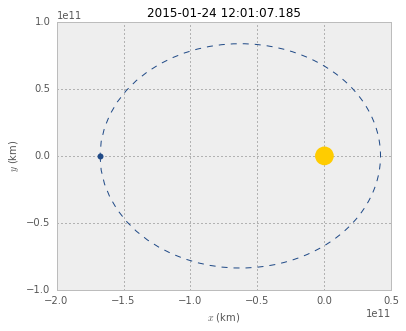

In [8]:
plot(planet9)

(Más abajo la representaremos junto a las órbitas de los planetas conocidos, pero la escala de la gráfica ya da una idea de las distancias que manejamos)

Pero es que aún hay más: la órbita del Planeta Nueve sería **bastante excéntrica**, y por la [segunda ley de Kepler](https://en.wikipedia.org/wiki/Kepler's_laws_of_planetary_motion#Second_law) la mayor parte del tiempo estará en la parte **más alejada**. Vamos a intentar visualizar las consecuencias de esta tercera ley pintando dos regiones "equiprobables" de la órbita, es decir: el Planeta Nueve estará el 50 % del tiempo cada una de ellas.

In [9]:
from matplotlib.patches import Wedge, PathPatch

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [10]:
# Transformamos las anomalías medias de 90 y 270 grados en
# anomalías verdaderas

nu_lower = angles.M_to_nu(1 * np.pi * u.rad / 2, planet9.ecc)
nu_upper = angles.M_to_nu(3 * np.pi * u.rad / 2, planet9.ecc)

# Regiones equiprobables

fifty_far = Wedge(
    (0, 0), planet9.r_a.to(u.km).value,
    nu_lower.to(u.deg).value, nu_upper.to(u.deg).value,
    color='#cccccc',
    zorder=0
)
fifty_close = Wedge(
    (0, 0), planet9.r_a.to(u.km).value,
    nu_upper.to(u.deg).value, nu_lower.to(u.deg).value,
    color='#999999',
    zorder=0
)

Para tener algo con lo que comparar vamos a pintar también las órbitas de la Tierra y Neptuno. Para ello poliastro utilizará unos ficheros llamados SPK que contienen información precisa sobre las órbitas de los planetas del sistema solar.

In [11]:
# Recuperamos la órbita de la Tierra para comparar

r_earth, v_earth = ephem.planet_ephem(ephem.EARTH, epoch)
earth = State.from_vectors(Sun, r_earth.to(u.km), v_earth.to(u.km / u.s), epoch)

# Y ya que nos ponemos, órbita de Neptuno

r_nep, v_nep = ephem.planet_ephem(ephem.PLUTO, epoch)
neptune = State.from_vectors(Sun, r_nep.to(u.km), v_nep.to(u.km / u.s), epoch)

Para el resto tendremos que jugar un poco con matplotlib y las funciones de plotting que proporciona poliastro.

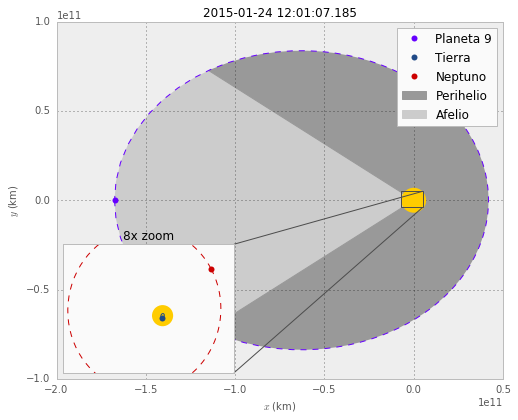

In [12]:
# Creamos la figura

fig, ax = plt.subplots(figsize=(8, 8))

op = OrbitPlotter(ax)
planet9_point, planet9_orbit = op.plot(planet9)

planet9_point.set_color("#6600ff")
planet9_orbit.set_color("#6600ff")

# Enmascaramos los sectores circulares con la órbita

mask = PathPatch(planet9_orbit.get_path(), fc='none', lw=0)

ax.add_patch(mask)
ax.add_patch(fifty_far)
ax.add_patch(fifty_close)

fifty_far.set_clip_path(mask)
fifty_close.set_clip_path(mask)

# Zoom en el sistema Solar

ax_zoom = zoomed_inset_axes(ax, 8, loc=3, axes_kwargs={'axisbg': '#fafafa'})

# Repetimos algunos plots

op_zoom = OrbitPlotter(ax_zoom)
op_zoom.set_frame(*planet9.pqw())
earth_point, earth_orbit = op_zoom.plot(earth)
nepune_point, _ = op_zoom.plot(neptune)

earth_orbit.set_linestyle("solid")  # ¡Para que se vea algo!

# Propiedades de la sección aumentada

ax_zoom.set_xlim(-7e9, 5e9)
ax_zoom.set_ylim(-4e9, 5e9)
ax_zoom.set_xticks([])
ax_zoom.set_yticks([])
ax_zoom.set_xlabel("")
ax_zoom.set_ylabel("")
ax_zoom.grid(False)
ax_zoom.set_title("8x zoom")
mark_inset(ax, ax_zoom, loc1=1, loc2=4, fc="none", ec='0.3')

# Leyenda de la gráfica

leg = ax.legend(
    [planet9_point, earth_point, nepune_point, fifty_close, fifty_far],
    ["Planeta 9", "Tierra", "Neptuno", "Perihelio", "Afelio"],
    numpoints=1
)
leg.get_frame().set_facecolor('#fafafa')

En este gráfico se aprecian dos cosas:

* Como hemos dicho antes, el Planeta Nueve pasa la mitad de su período en la parte más alejada del Sol (y por tanto, de nosotros), el **afelio** (sector gris claro). En cambio, la otra mitad del tiempo se la pasa acelerando hacia el **perihelio**. Es evidente entonces que lo más probable es que el planeta esté más lejos que cerca.
* Y hablando de lejos: está muy lejos. *Extremadamente lejos*. Por supuesto está cerca comparado con Alfa Centauri, pero precisamente lo novedoso de este caso es que nadie esperaba encontrar un planeta con un tamaño tan considerable a una distancia tan grande.

Otra forma de comprobar la enormidad de estas distancias es tratando de averiguar cuánto nos costaría llegar hasta allí. ¡Sigue leyendo!

## ¿Cómo llegamos hasta allí?

<div class="alert alert-warning">**Importante**: Estos resultados son provisionales y están pendientes de revisión por problemas con el algoritmo, que no converge bien. De hecho se observa que he tenido que especificar una tolerancia relativa desmesurada. Después del tiempo dedicado he preferido publicar el código, que al menos muestra cómo utilizar la biblioteca, a pesar de que haya hecho aflorar sus limitaciones. [Ya he abierto una incidencia en poliastro](https://github.com/poliastro/poliastro/issues/112) para ver dónde está el problema, aunque posiblemente se deba a la fuerte inestabilidad numérica que supone acertar una diana que está a 168 000 000 000 km.</div>

Ahora es donde empieza de verdad la ciencia ficción. Vamos a estudiar algunas trayectorias posibles que podríamos seguir para llegar a este hipotético Planeta Nueve, aunque lamentablemente obtengamos tiempos de cientos de años o velocidades inalcanzables con nuestra tecnología :)

### Primera opción: Viaje directo

Supongamos que lanzamos la nave la semana que viene (no hay tiempo que perder) y que nos planteásemos llegar en un tiempo optimista: 200 años. Supongamos también que en el momento del lanzamiento tenemos al Planeta Nueve en su afelio, que de hecho es el caso peor. El problema de calcular qué velocidad necesitamos para llegar se llama **problema de Lambert**, y con poliastro lo podemos resolver.

In [13]:
from poliastro import iod
from poliastro.util import norm

In [14]:
date_launch = time.Time('2016-02-01 12:00', scale='utc').tdb
time_of_flight = 200 * u.year
date_arrival = date_launch + time_of_flight

r_0, v_earth = ephem.planet_ephem(ephem.EARTH, date_launch)

r_f = planet9.propagate(time_of_flight).r

v_0, v_f = iod.lambert(Sun.k, r_0, r_f, time_of_flight, rtol=5)

Veamos la magnitud de la velocidad de partida:

In [15]:
(norm(v_0 - v_earth)).to(u.km / u.h)

<Quantity 224320.63064931866 km / h>

No es demasiado descabellada, teniendo en cuenta que la velocidad de lanzamiento de New Horizons (que llegó a Plutón en menos de 10 años) fue de casi 60 000 km/h. Veamos ahora esta trayectoria:

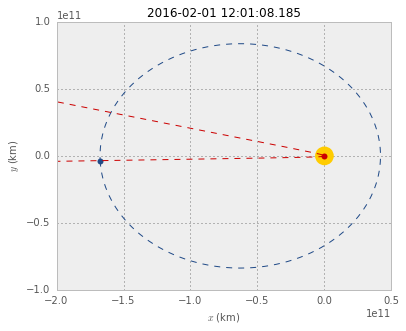

In [16]:
traj1 = State.from_vectors(
    Sun,
    r_0.to(u.km),
    v_0.to(u.km / u.s),
    date_launch
)

op = OrbitPlotter(num_points=10000)

op.plot(planet9.propagate(time_of_flight))
#op.plot(earth)
plt.gca().set_autoscale_on(False)
op.plot(traj1)

Prácticamente en línea recta, ¡como si fuese esto una autopista! Lamentablemente 200 años es demasiado tiempo, y si intentamos reducirlo los requisitos de velocidad solo empeorarían. Veamos otras opción un poco más loca.

### Efecto Oberth con el Sol

Al leer esta posibilidad no he podido evitar acordarme de la entrañable viñeta de XKCD:

![Obert](http://imgs.xkcd.com/comics/six_words.png)

El efecto Oberth es el hecho de que *las maniobras impulsivas son más eficientes cuanto más rápido va el vehículo*. Gracias a esto se podría diseñar una trayectoria que pasase muy cerca del Sol y que efectuase un gran impulso en el perihelio. La secuencia de la viñeta es demasiado complicada así que vamos a dividir este recorrido en dos partes:

1. Una transferencia de Hohmann a 38 millones de kilómetros del Sol, y
2. un impulso para alcanzar la órbita del Planeta Nueve en 100 años.

Veremos qué números obtenemos ahora:

In [17]:
from poliastro.maneuver import Maneuver

In [18]:
hoh = Maneuver.hohmann(earth, 38e6 * u.km)
hoh.get_total_cost()

<Quantity 26.644521834769144 km / s>

El frenazo que tenemos que pegar es considerable. Viajemos ahora al perihelio y efectuemos la transferencia.

In [19]:
interm = earth.apply_maneuver(hoh)
perih = interm.propagate(interm.period / 2)
norm(perih.r)

<Quantity 37630209.77673668 km>

In [20]:
norm(perih.v)

<Quantity 59.62560141879157 km / s>

La diferencia de radios se debe a que no partíamos de una órbita circular. Nos hemos saltado el paso de circularizar la órbita para simplificar.

Por último, rezamos para que el algoritmo del problema de Lambert converja y nos lleve hasta el Planeta Nueve:

In [21]:
v_i, _ = iod.lambert(Sun.k, perih.r.to(u.km), planet9.r.to(u.km), 100 * u.year, rtol=12)  # De nuevo, tolerancia demasiado grande
norm(v_i)

<Quantity 84.05882035151672 km / s>

Y el requisito total de velocidad será:

In [22]:
hoh.get_total_cost() + norm(v_i - perih.v)

<Quantity 149.0633339332227 km / s>

Caramba, ¡mucho más alto que antes! Intentamos pintarlo todo:

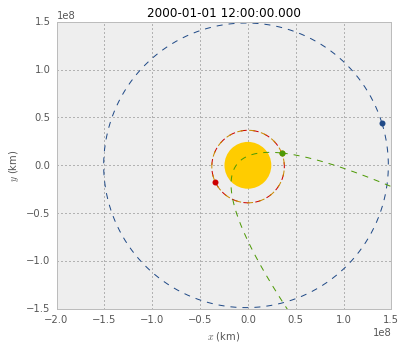

In [23]:
op = OrbitPlotter(num_points=10000)

op.plot(earth)
op.plot(interm)
op.plot(perih)
plt.gca().set_autoscale_on(False)
#op.plot(planet9)
op.plot(State.from_vectors(Sun, perih.r, v_i))

El motivo del altísimo coste de la maniobra es ese cambio radical de dirección en la trayectoria heliocéntrica que le hemos exigido a nuestra misión. Como se ha señalado arriba, esta forma de calcular la trayectoria tiene numerosos problemas y necesita una revisión urgente.

## Conclusiones

El otro día señalaban por Twitter que [también debemos publicar los resultados negativos](http://scitechconnect.elsevier.com/why-science-needs-to-publish-negative-results), y aquí están los míos. Por un lado, poliastro tiene algunas limitaciones en sus algoritmos que han puesto en duda la precisión de los resultados, aunque en las gráficas no se aprecie demasiado. Por otro lado, esta forma de diseñar las trayectorias es demasiado apresurada y conduce a situaciones absurdas, así que el tema merece más tiempo incluso a este nivel divulgativo y nada riguroso (más que los cuatro días que he tardado yo en publicar esto). En el próximo mes y medio estaré trabajando intensamente en poliastro así que posiblemente pueda hacer avances en este sentido :)

Querría desde aquí agradecer a las [más de 100 personas que me retuitearon el viernes en Pybonacci](
https://twitter.com/Pybonacci/status/690554406442569730) y a Daniel Marín por la increíble calidad de sus artículos (mucho más finos que estos por suerte).

¡Un saludo y hasta el próximo artículo!